In [1]:
import sys  
sys.path.insert(0, '/Users/johanneswidera/Uni/bachelorarbeit/Code/models/')

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import pandas as pd
import numpy as np
from sklearn import linear_model
from bs4 import BeautifulSoup
import contractions
import os
import re
import string
from model_helper.tf_idf import build_tf_idf
from model_helper.PipelineWrapper import PipelineWrapper
from model_helper.predict_and_save import predict_and_save
from custom_shap_explainer.custom_global import custom_global_explanation, custom_global_shap_distribution,custom_global_boxplot
from custom_shap_explainer.signal_words import highlight_signal_words
np.random.seed(1337)
shap.initjs()

/Users/johanneswidera/Uni/bachelorarbeit/Code/models/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/johanneswidera/Uni/bachelorarbeit/Code/models/HUGGING_ENV/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-ba

# 1. Get Training Data 

In [3]:
def preprocessor(text):
  text = text.lower()
  text = contractions.fix(text)
  text = text.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
  text = re.sub(' +', ' ', text)
  return text 

def load_data(source):
  data = pd.read_csv(source)
  # select only 2 columns
  data = data[['candidate', 'label']]
  # rename columns
  data.columns = ['text', 'label']
  data['text'] = data['text'].apply(preprocessor)
  return data['text'].tolist(), data['label'].tolist()

In [4]:
corpus_train, y_train = load_data('../data/train.csv')
corpus_test, y_test = load_data('../data/test.csv')

# 2. Build Vectorizer

In [5]:
vectorizer_tf_idf = build_tf_idf()
vectorizer_tf_idf.fit(corpus_train)

TfidfVectorizer(max_df=0.99, min_df=0.001)

# 3. Build Models

# 3.1 Build Logistic Regression Model

In [6]:
model = linear_model.LogisticRegression(penalty="l2")
model_logregression_new = PipelineWrapper(model, vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [7]:
model_logregression_new.fit()

In [8]:
model_logregression_new.report()

,0,1,accuracy,macro avg,weighted avg
precision,0.650876,0.819209,0.668219,0.735043,0.717798
recall,0.969082,0.212299,0.668219,0.590690,0.668219
f1-score,0.778727,0.337209,0.668219,0.557968,0.603199
support,1035.000000,683.000000,0.668219,1718.000000,1718.000000


In [9]:
LOGREG_PREDICTION_FILE = 'predictions_logreg.csv'

file_exists = os.path.exists(LOGREG_PREDICTION_FILE)

if not file_exists:
    predict_and_save(model_logregression_new, 'logreg', corpus_test, LOGREG_PREDICTION_FILE)

# 3.2 Build Decision Tree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(min_samples_leaf=20)
model_dtc = PipelineWrapper(model, vectorizer_tf_idf, corpus_test, corpus_train, y_test, y_train)

In [11]:
model_dtc.fit()

In [12]:
model_dtc.report()

,0,1,accuracy,macro avg,weighted avg
precision,0.650432,0.534831,0.620489,0.592632,0.604474
recall,0.800000,0.348463,0.620489,0.574231,0.620489
f1-score,0.717504,0.421986,0.620489,0.569745,0.600019
support,1035.000000,683.000000,0.620489,1718.000000,1718.000000


In [13]:
print(model_dtc.predict_proba([corpus_test[0]]))

[[0.96969697 0.03030303]]


In [14]:
DTC_PREDICTION_FILE = 'predictions_dtc.csv'

file_exists = os.path.exists(DTC_PREDICTION_FILE)

if not file_exists:
    predict_and_save(model_dtc, 'dtc', corpus_test, DTC_PREDICTION_FILE)

# 3.3 Build BERT

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("jowid100/FineTunedBERTArgument")
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained("jowid100/FineTunedBERTArgument")
model_bert = pipeline('text-classification', model=loaded_model, tokenizer=tokenizer, max_length=512, truncation=True, top_k=None) 

In [16]:
BERT_PREDICTION_FILE = 'prediction_BERT.csv'

file_exists = os.path.exists(BERT_PREDICTION_FILE)

if not file_exists:
    # Calculate BERT predictions
    raw_predictions_bert = model_bert.predict(corpus_test)

    # Destructure probabilities for class_1 and class_2
    predictions_class_0 = [pred[0]['score'] if pred[0]['label'] == 'LABEL_0' else pred[1]['score'] for pred in raw_predictions_bert]
    predictions_class_1 = [pred[0]['score'] if pred[0]['label'] == 'LABEL_1' else pred[1]['score'] for pred in raw_predictions_bert]

    # Create a DataFrame containing the test samples and BERT predictions
    results = pd.DataFrame({
        'bert_0': predictions_class_0,
        'bert_1': predictions_class_1
    })

    # Save the DataFrame to a CSV file
    results.to_csv(BERT_PREDICTION_FILE)

# 4 Analyze With SHAP

We know that the Logistic Regression Performs better than the Decision Tree Classifier.
To further investigate why thats the case we need to look into the models.

In the following i will do 3 things.

Per Model:
1. Most Positive/Negative Words
2. Investigate the Most Wrong Positive and Negative prediction

Model Comparision:
1. Investigate biggest Prediction gap accross the models

## what is a claim?
The guidelines provided to the annotators present mainly 3 criteria, which all have to be met for a positive label.

1. The sentence must clearly support or contest the topic, and not simply be neutral.
2. It has to be coherent and stand mostly on its own.
3. It has to be convincing, something you could use to sway someone's stance on the topic (a claim is not enough, it has to be backed up).

In [17]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
# explainer_logreg = shap.Explainer(model_logregression_new.predict_proba , masker)
explainer_logreg = shap.Explainer(model_logregression_new.predict_proba, masker)


In [18]:
# Performance Optimazation

import os.path
import pickle

shap_values_file = "shap_values_logreg.pkl"

# Überprüfen, ob die Datei existiert
if not os.path.exists(shap_values_file):
    # Berechnen Sie die SHAP-Werte, wenn die Datei nicht existiert
    shap_values_logreg = explainer_logreg(corpus_test)

    # Speichern Sie die SHAP-Werte in einer Datei
    with open(shap_values_file, "wb") as f:
        pickle.dump(shap_values_logreg, f)
else:
    # Laden Sie die SHAP-Werte aus der Datei, wenn sie existiert
    with open(shap_values_file, "rb") as f:
        shap_values_logreg = pickle.load(f)

### 4.1 Investigate the biggest misclassification


In [19]:
from Sentiment.disagreements import get_misclassifications
logreg_misclassifications = get_misclassifications(y_test,LOGREG_PREDICTION_FILE)

In [20]:

print("total samples", len(y_test))
print("total misclassifications", len(logreg_misclassifications))

# count number of samples for label 1 and label 0
label_0 = y_test.count(0)
label_1 = y_test.count(1)



# print number of samples for label 1 and label 0

print("Number of samples for label 0: ", label_0)
print("Number of samples for label 1: ", label_1)

# count missclassifications for class 0 and for class 1

logreg_misclassifications_0 = logreg_misclassifications[(logreg_misclassifications['label'] == 0)]
logreg_misclassifications_1 = logreg_misclassifications[(logreg_misclassifications['label'] == 1)]

# print the number of missclassifications for class 0 and for class 1
print("Number of missclassifications for class 0: ", len(logreg_misclassifications_0))
print("Number of missclassifications for class 1: ", len(logreg_misclassifications_1))


# calculate the percentage of missclassifications for class 0 and for class 1
percentage_0 = len(logreg_misclassifications_0) / label_0
percentage_1 = len(logreg_misclassifications_1) / label_1

# print the percentage of missclassifications for class 0 and for class 1
print("Percentage of missclassifications for class 0: ", percentage_0)
print("Percentage of missclassifications for class 1: ", percentage_1)

total samples 1718
total misclassifications 570
Number of samples for label 0:  1035
Number of samples for label 1:  683
Number of missclassifications for class 0:  32
Number of missclassifications for class 1:  538
Percentage of missclassifications for class 0:  0.030917874396135265
Percentage of missclassifications for class 1:  0.787701317715959


In [21]:
# find first with label = 0
logreg_misclassifications[:5]

,logreg_0,logreg_1,label,diff,misclassified
797,0.898298,0.101702,1,0.898298,True
188,0.883841,0.116159,1,0.883841,True
1602,0.880279,0.119721,1,0.880279,True
784,0.873129,0.126871,1,0.873129,True
228,0.871797,0.128203,1,0.871797,True


In [22]:
most_wrong_positive_index = 797

#### 4.1.2 Most Wrong Positive Classification

Most wrong review 

In [23]:
print(logreg_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])

logreg_0         0.898298
logreg_1         0.101702
label                   1
diff             0.898298
misclassified        True
Name: 797, dtype: object
on 14 january 2009 the university of ottawa centre for international policy studies directed by professor roland paris published the following statement on freedom of speech freedom of speech is a core value of canadian society especially within its universities where the expression and debate of different positions is crucial to learning 


In [24]:
explanation = shap_values_logreg[most_wrong_positive_index, :, 1]

so its 0.5 behind the real label.
But Why lets investigate

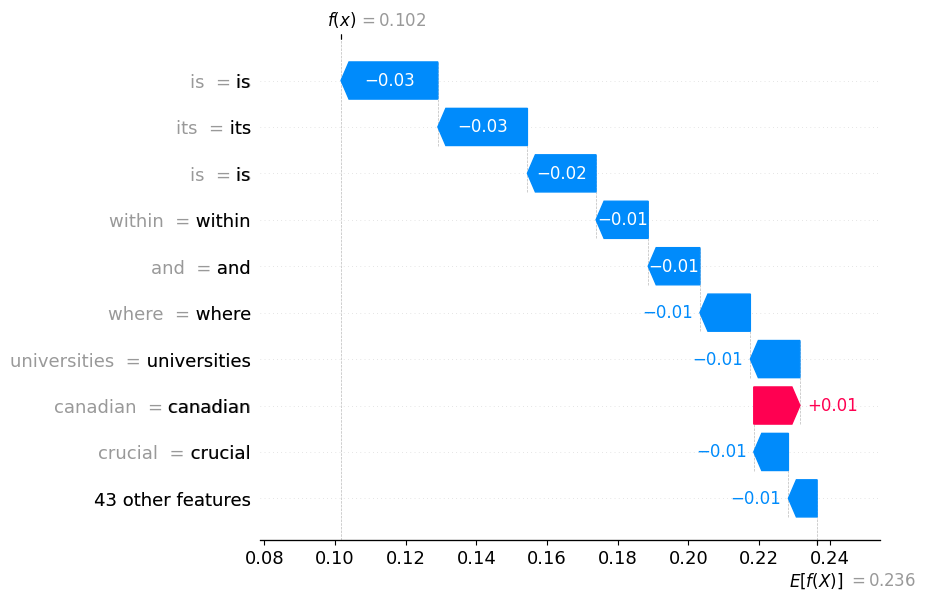

In [25]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

highlight_signal_words(explanation, round_shap_values=3, top_words=4)

### interpretation:

This is a claim but the model is not able to capture the classification correctly. Because it weights the no-claim words (like: is its is) more than the claim words

#### 4.1.2 Most Wrong Negative Classification

Most wrong review 

In [26]:
# find first with label = 0
most_wrong_negative_index = logreg_misclassifications[logreg_misclassifications['label'] == 0].index[0]

In [27]:
print(logreg_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])

logreg_0         0.262407
logreg_1         0.737593
label                   0
diff             0.737593
misclassified        True
Name: 245, dtype: object
the libertarian party supports the legalization of drugs ref ref ref ref pornography ref prostitution ref ref ref ref gambling ref removal of restrictions on homosexuality ref opposes any kind of censorship and supports freedom of speech ref and supports the right to keep and bear arms ref 


In [28]:
explainer = shap_values_logreg[most_wrong_negative_index, : , 1]

48


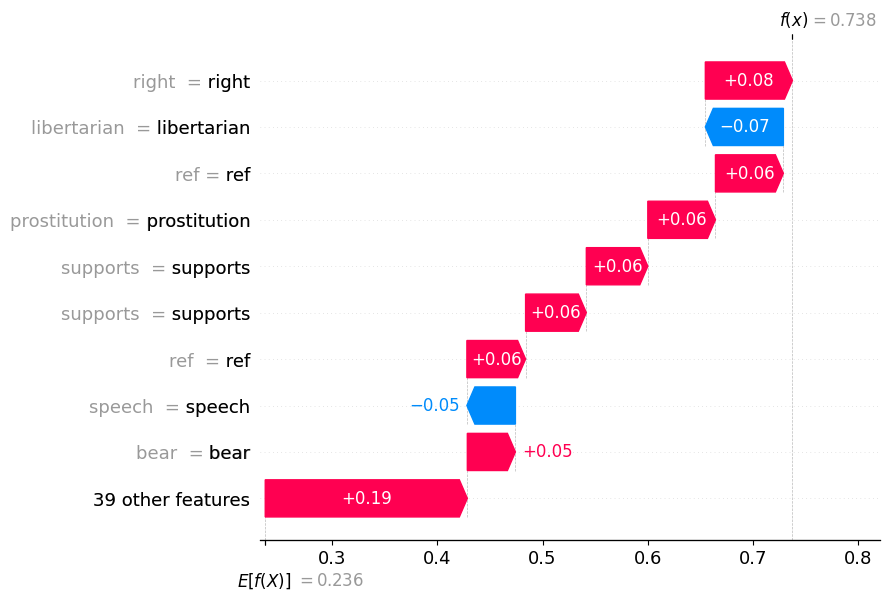

In [29]:
shap.plots.text(explainer)
print(len(explainer))
shap.plots.waterfall(explainer)
highlight_signal_words(explainer,round_shap_values=3,top_words=5)

# Interpretation:

THis is a neutral observation ergo no claim but the words:
- right
- libertarian
- ref
- prostituion
- supports
- bear

have high positive impact on the classification.

Furthermore the model is not really learning why this is not a claim it dont knows that 

# 4.2 Global Interpretation Most Positive and negative Words

To understand how the model works

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


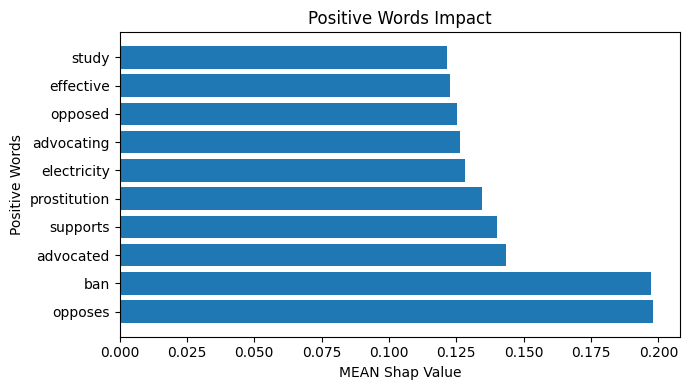

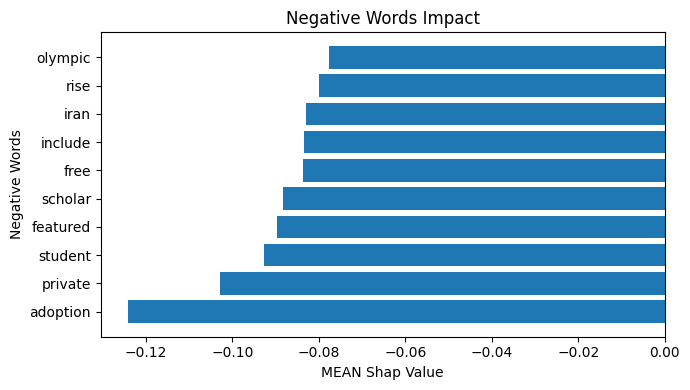

In [30]:
custom_global_explanation(shap_values_logreg[:,:,1], num_words=10)

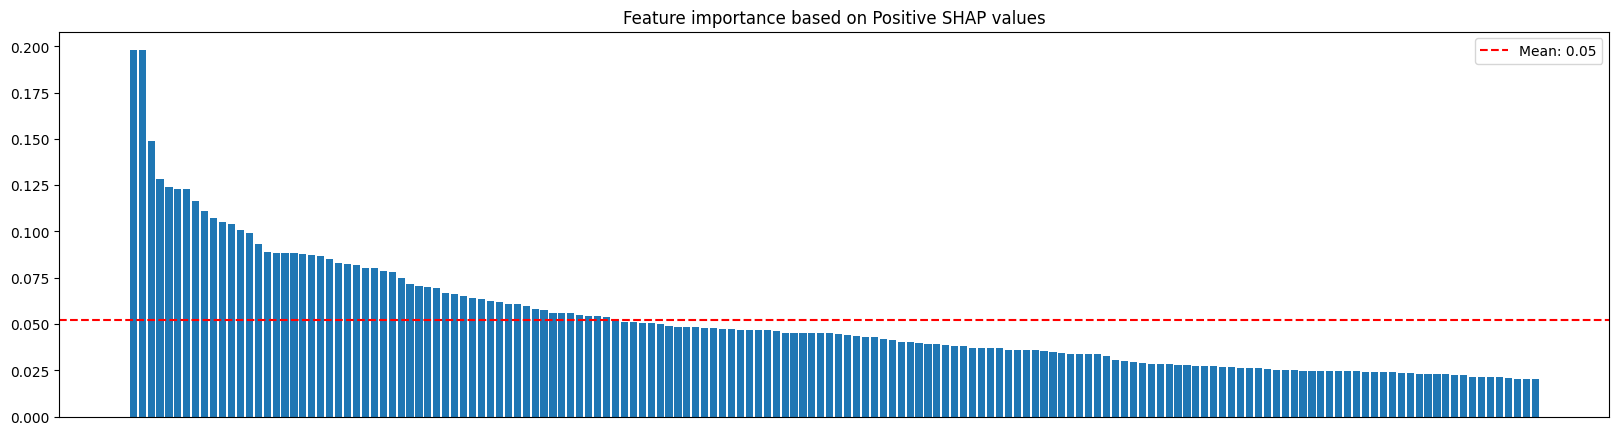

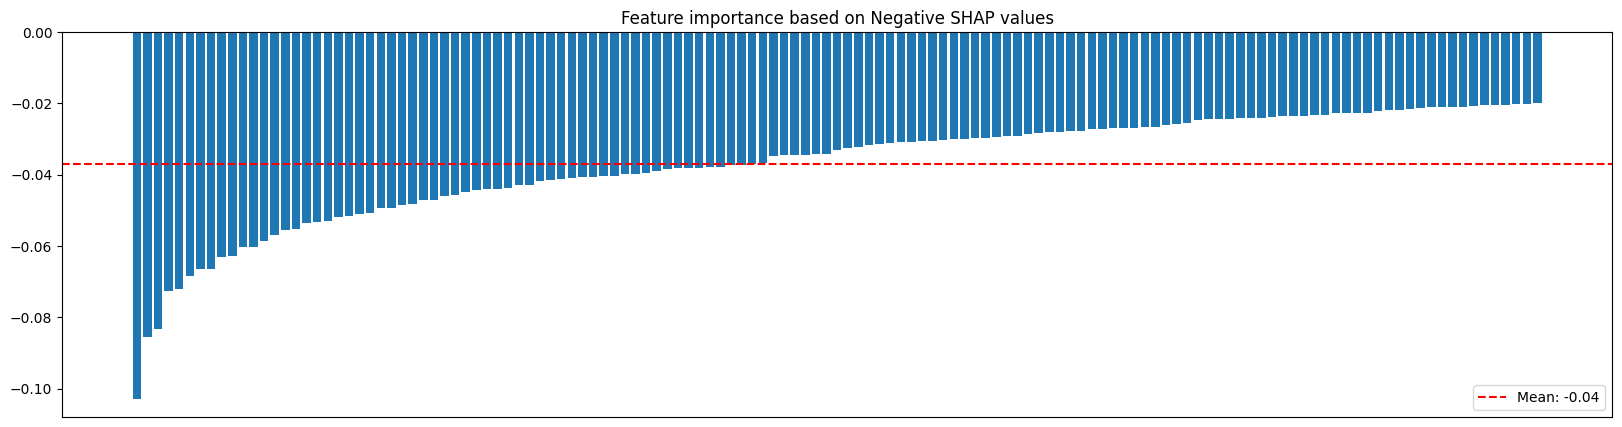

In [31]:
custom_global_shap_distribution(shap_values_logreg[:,:,1], threshold=0.02)

## Interpretation

The most important Words Contributing to a Claim Classification:

1. opposes
2. ban
3. supports
4. opposed

with the highest shap value of 0.2 of oppeses

The most important Words Contributing to a no-claim classification:

1. Private
2. free 
3. include
4. other

with the highest shap value of -0.1 

you can see that the model pays more attention to the words that are characteristic for a claim classification and less to words that are non-claim charateristic.


but maybe as soon as the main claim classification words are not present it struggles to identify a sample as claim.


This fits to our previous observation were i looked for the misclassified classes and the biggest misclassifications.
Percentage of missclassifications for class 0:  0.030917874396135265
Percentage of missclassifications for class 1:  0.787701317715959

# 5. Analyze with SHAP: DTC

In [32]:
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
# explainer_logreg = shap.Explainer(model_logregression_new.predict_proba , masker)
explainer_dtc = shap.Explainer(model_dtc.predict_proba, masker)

In [33]:
# Performance Optimazation

import os.path
import pickle

shap_values_file = "shap_values_dtc.pkl"

# Überprüfen, ob die Datei existiert
if not os.path.exists(shap_values_file):
    # Berechnen Sie die SHAP-Werte, wenn die Datei nicht existiert
    shap_values_dtc= explainer_dtc(corpus_test)

    # Speichern Sie die SHAP-Werte in einer Datei
    with open(shap_values_file, "wb") as f:
        pickle.dump(shap_values_dtc, f)
else:
    # Laden Sie die SHAP-Werte aus der Datei, wenn sie existiert
    with open(shap_values_file, "rb") as f:
        shap_values_dtc = pickle.load(f)

# 5.1 Investigate Biggest Misclassifications


In [34]:
dtc_misclassifications = get_misclassifications(y_test, DTC_PREDICTION_FILE)


In [35]:

print("total samples", len(y_test))
print("total misclassifications", len(dtc_misclassifications))

# count number of samples for label 1 and label 0
label_0 = y_test.count(0)
label_1 = y_test.count(1)



# print number of samples for label 1 and label 0

print("Number of samples for label 0: ", label_0)
print("Number of samples for label 1: ", label_1)

# count missclassifications for class 0 and for class 1

dtc_misclassifications_0 = dtc_misclassifications[(dtc_misclassifications['label'] == 0)]
dtc_misclassifications_1 = dtc_misclassifications[(dtc_misclassifications['label'] == 1)]

# print the number of missclassifications for class 0 and for class 1
print("Number of missclassifications for class 0: ", len(dtc_misclassifications_0))
print("Number of missclassifications for class 1: ", len(dtc_misclassifications_1))


# calculate the percentage of missclassifications for class 0 and for class 1
percentage_0 = len(dtc_misclassifications_0) / label_0
percentage_1 = len(dtc_misclassifications_1) / label_1

# print the percentage of missclassifications for class 0 and for class 1
print("Percentage of missclassifications for class 0: ", percentage_0)
print("Percentage of missclassifications for class 1: ", percentage_1)

total samples 1718
total misclassifications 652
Number of samples for label 0:  1035
Number of samples for label 1:  683
Number of missclassifications for class 0:  207
Number of missclassifications for class 1:  445
Percentage of missclassifications for class 0:  0.2
Percentage of missclassifications for class 1:  0.6515373352855052


In [36]:
dtc_misclassifications[:10]

,dtc_0,dtc_1,label,diff,misclassified
1073,1.0,0.0,1,1.0,True
1080,1.0,0.0,1,1.0,True
422,1.0,0.0,1,1.0,True
1608,1.0,0.0,1,1.0,True
704,1.0,0.0,1,1.0,True
920,1.0,0.0,1,1.0,True
1036,1.0,0.0,1,1.0,True
915,1.0,0.0,1,1.0,True
906,1.0,0.0,1,1.0,True
901,1.0,0.0,1,1.0,True


# 5.1.2 Most Wrong Positive classification

In [37]:
most_wrong_positive_index = 1073
explanation = shap_values_dtc[most_wrong_positive_index, :, 1]
print(dtc_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])


dtc_0             1.0
dtc_1             0.0
label               1
diff              1.0
misclassified    True
Name: 1073, dtype: object
waste of the mining industry poses a direct threat to the environment of both kyrgyzstan and neighboring countries 


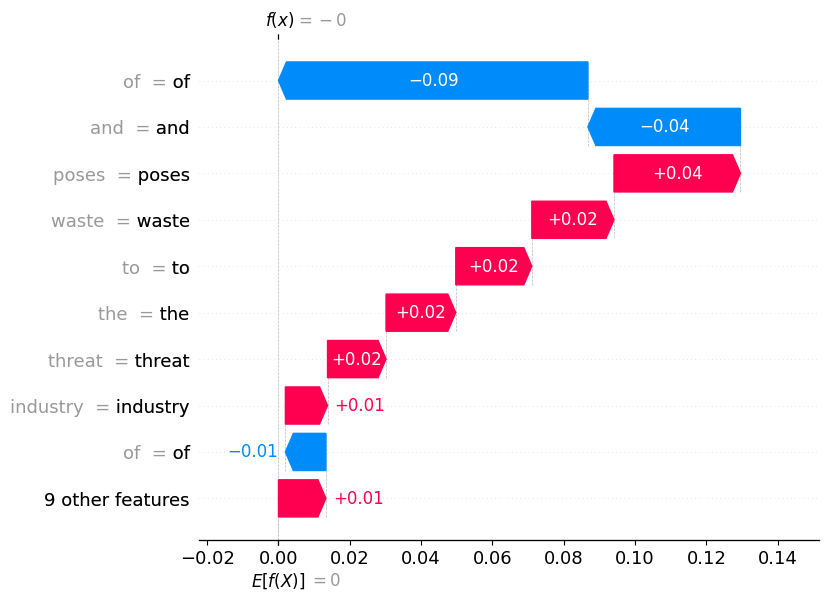

In [38]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [39]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

#### interpretation:

Why is this a claim?

# 5.1.2 Most Wrong Negative

In [40]:
most_wrong_negative_index = dtc_misclassifications[dtc_misclassifications['label'] == 0].index[0]
most_wrong_negative_index


744

In [41]:
explanation = shap_values_dtc[most_wrong_negative_index, :, 1]
print(dtc_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])

dtc_0            0.076923
dtc_1            0.923077
label                   0
diff             0.923077
misclassified        True
Name: 744, dtype: object
a study showed that five percent of single fathers were fired form their jobs due to the double burden and another eight percent quit because the double burden became too much of a burden for them to balance both work and the family ref 


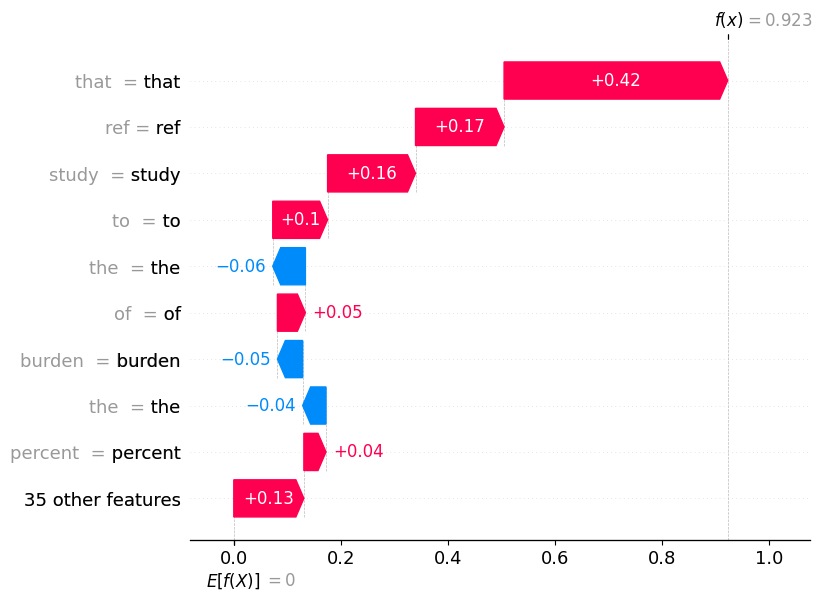

In [42]:
shap.plots.text(explanation)
shap.plots.waterfall(explanation)
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

### interpretation
Thats not a claim.

but the model learned that the word "that" is introduction for a claim that is not the case.
in this case its only an introduction for a study...

# 5.2 Global Effects

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


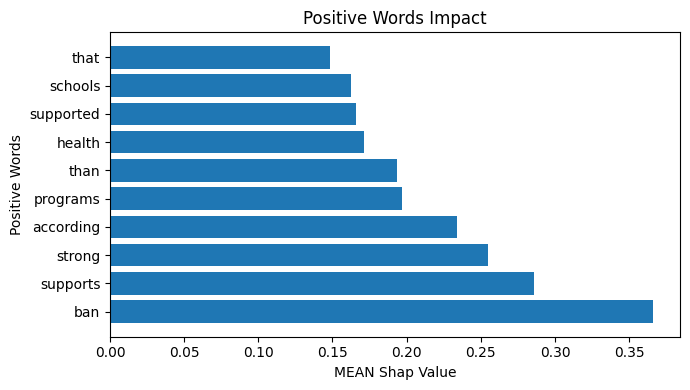

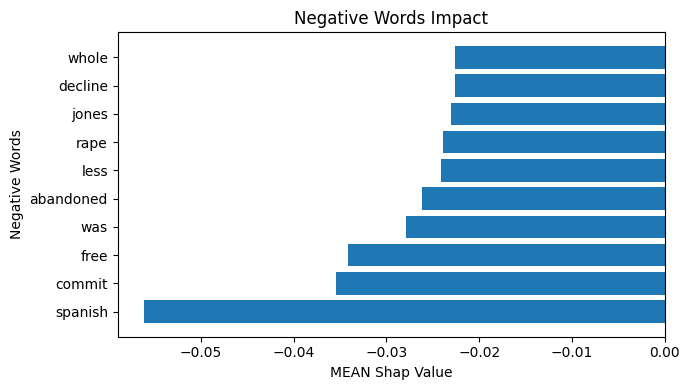

In [43]:
custom_global_explanation(shap_values_dtc[:,:,1])

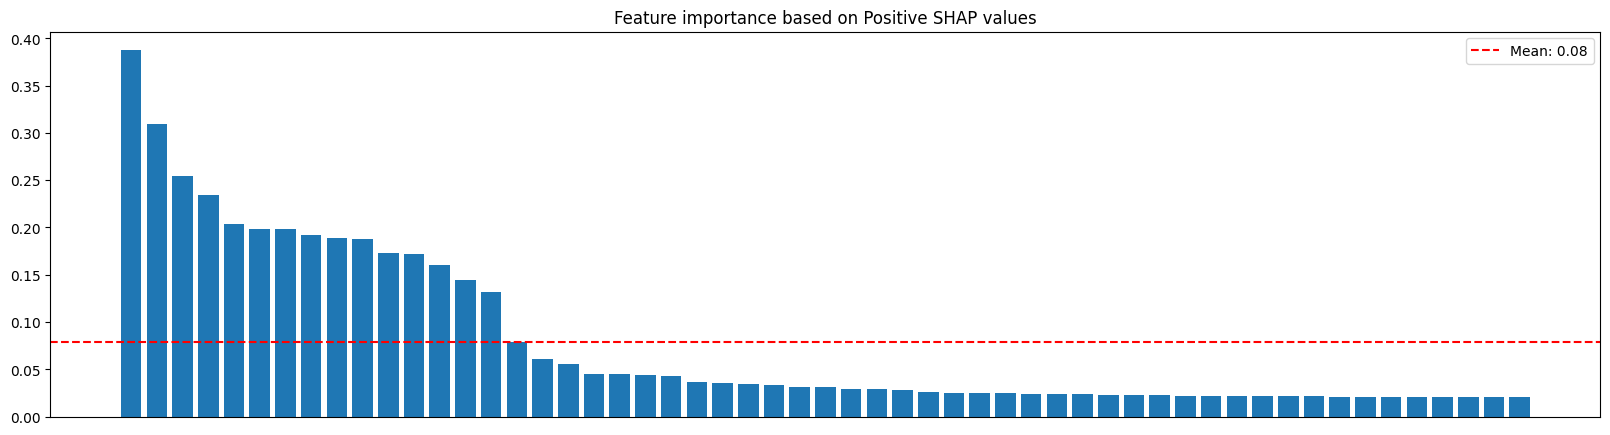

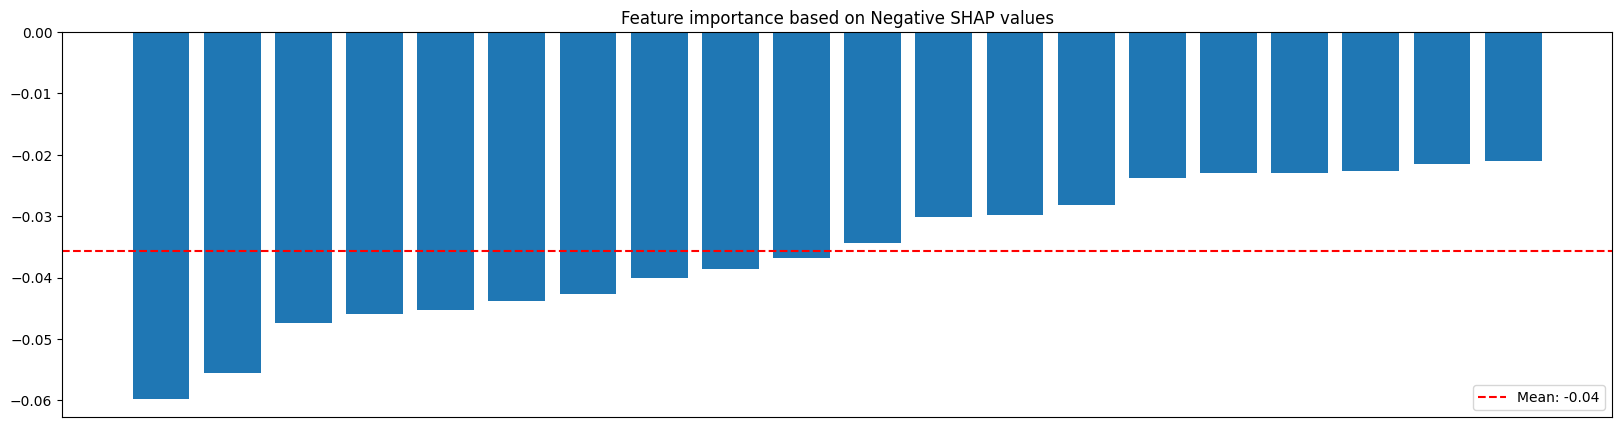

In [44]:
custom_global_shap_distribution(shap_values_dtc[:,:,1], threshold=0.02)

### interpretation

you can see shap values that contributing to claim are way more above the threshold than the shap values contributing against a claim.

What are the impacts of this?

-> the models classifies way more as claim than as no-claim because it has way more words that contribute to class 1.





# 6. SHAP for BERT

In [45]:
""" 

In summary, the reason your code is not using the GPU is that the SHAP library does not support GPU acceleration for BERT models. Unfortunately, there is no direct solution to this issue. You can try looking for alternative libraries or methods that support GPU acceleration for BERT or similar text models.
 """

# Performance Optimazation
masker = shap.maskers.Text(tokenizer=r"\W+") # this will create a basic whitespace tokenizer
# explainer_logreg = shap.Explainer(model_logregression_new.predict_proba , masker)
explainer_bert = shap.Explainer(model_bert, masker)
import os.path
import pickle

shap_values_file = "shap_values_bert.pkl"

# Überprüfen, ob die Datei existiert
if not os.path.exists(shap_values_file):
    # Berechnen Sie die SHAP-Werte, wenn die Datei nicht existiert
    shap_values_bert= explainer_bert(corpus_test)

    # Speichern Sie die SHAP-Werte in einer Datei
    with open(shap_values_file, "wb") as f:
        pickle.dump(shap_values_bert, f)
else:
    # Laden Sie die SHAP-Werte aus der Datei, wenn sie existiert
    with open(shap_values_file, "rb") as f:
        shap_values_bert = pickle.load(f)

# 6.1 Investigate biggest Misclassifications

In [46]:
dtc_misclassifications = get_misclassifications(y_test, BERT_PREDICTION_FILE)

## 6.1.2 Investigate biggest Misclassifications


In [47]:
most_wrong_positive_index = 210

explanation = explainer_bert([corpus_test[most_wrong_positive_index]])
explanation = explanation[0, :, 1]

Partition explainer: 2it [00:11, 11.91s/it]               


bert_0           0.991949
bert_1           0.008051
label                   1
diff             0.991949
misclassified        True
Name: 210, dtype: object
 death warns against such misplaced values and condemns the practice of censorship as well as demonstrating there can be value in a show often dismissed as juvenile and immature like south park or terrance and phillip ref 


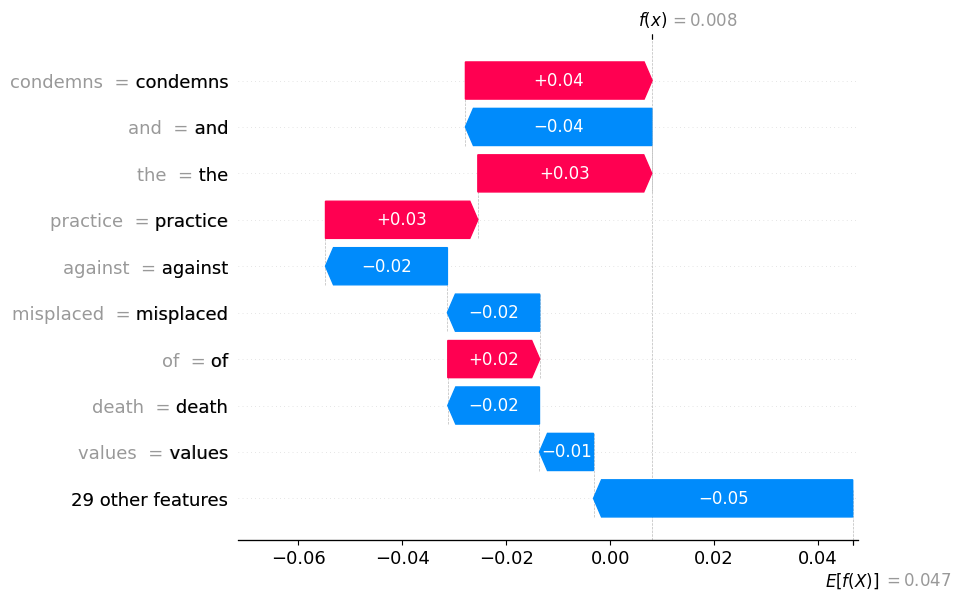

In [48]:
print(dtc_misclassifications.loc[most_wrong_positive_index])
print(corpus_test[most_wrong_positive_index])
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [49]:
highlight_signal_words(explanation,round_shap_values=3,top_words=10)

### Interpretation

This is a claim but BERT fails to classify it as such:
claim: death warns against such misplaced values and condemns the practice of censorship as well as demonstrating there can be value in a show often dismissed as juvenile and immature
Prove: like south park or terrance and phillip ref

# 6.1.2 Biggest Negative misclassification

In [50]:
most_wrong_negative_index = 1024

explanation = explainer_bert([corpus_test[most_wrong_negative_index]])
explanation = explanation[0, :, 1]

Partition explainer: 2it [00:10, 10.95s/it]               


bert_0           0.024896
bert_1           0.975104
label                   0
diff             0.975104
misclassified        True
Name: 1024, dtype: object
a ucla study concluded that extending marriage to same sex couples will boost the district of columbia s economy by over 52 2 million over three years which would generate increases in local government tax and fee revenues by 5 4 million and create approximately 700 new jobs ref 


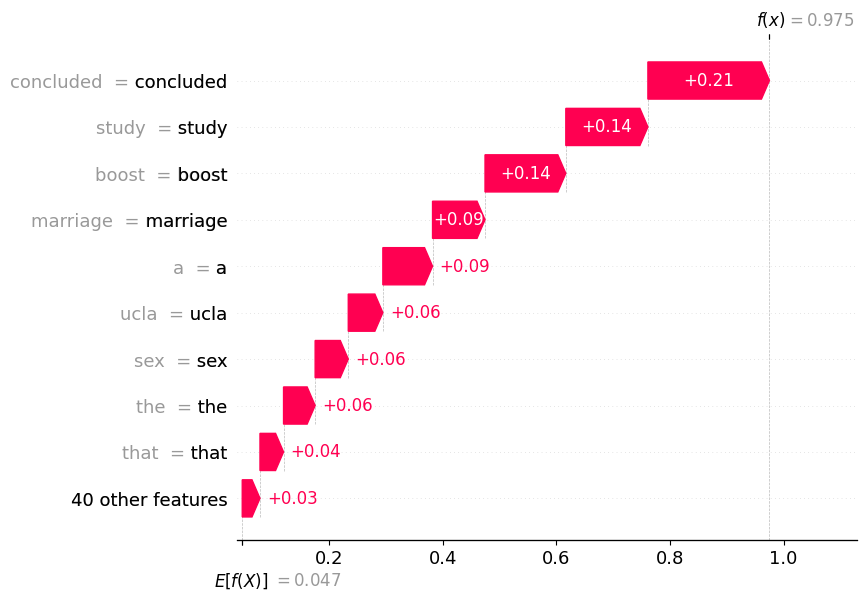

In [51]:
print(dtc_misclassifications.loc[most_wrong_negative_index])
print(corpus_test[most_wrong_negative_index])
shap.plots.text(explanation)
shap.plots.waterfall(explanation)

In [52]:
highlight_signal_words(explanation,round_shap_values=3,top_words=4)

### interpretation

The model learned that "study concluded" are words that lead to a claim.
I think its not labeled as a claim because its a neutral view on a study

# 6.2 Global Explanation



Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


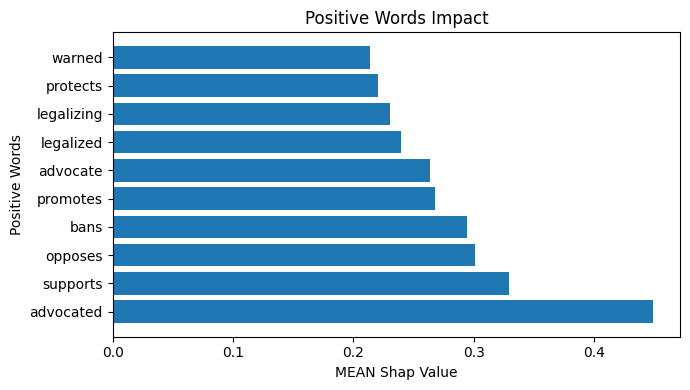

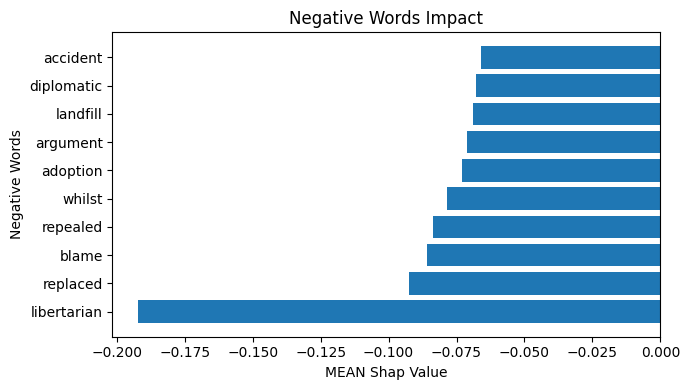

In [53]:
custom_global_explanation(shap_values_bert[:,:,1])

Started custom_global_boxplot


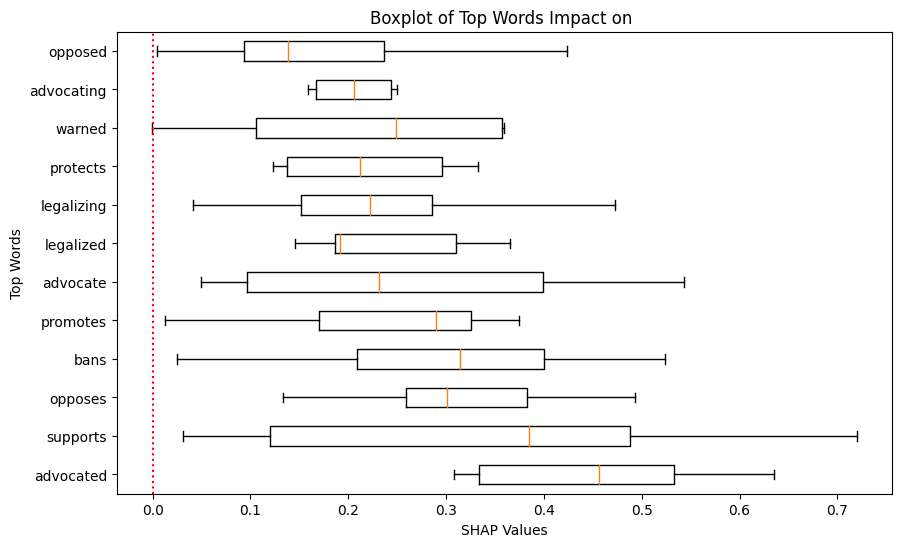

In [54]:
custom_global_boxplot(shap_values_bert[:,:,1], num_words=12)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Started custom_global_boxplot


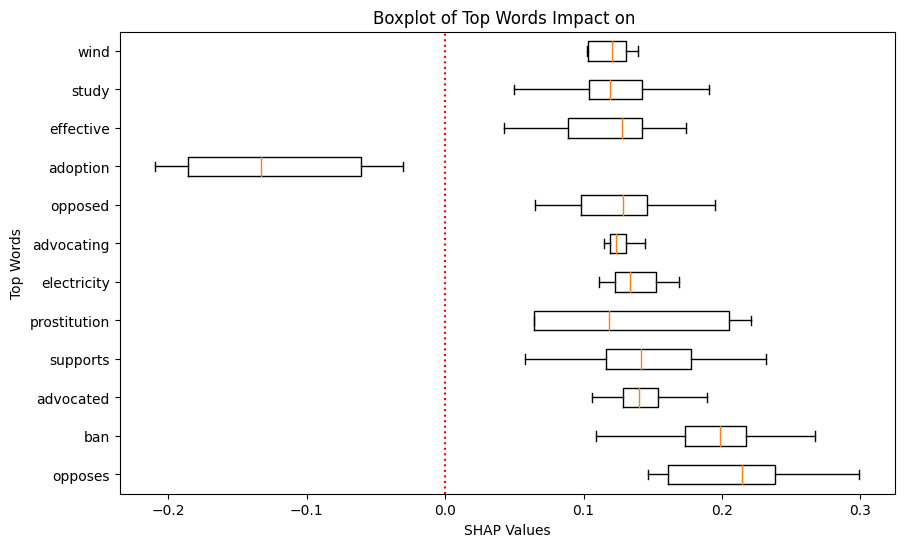

In [55]:
custom_global_boxplot(shap_values_logreg[:,:,1], num_words=12)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


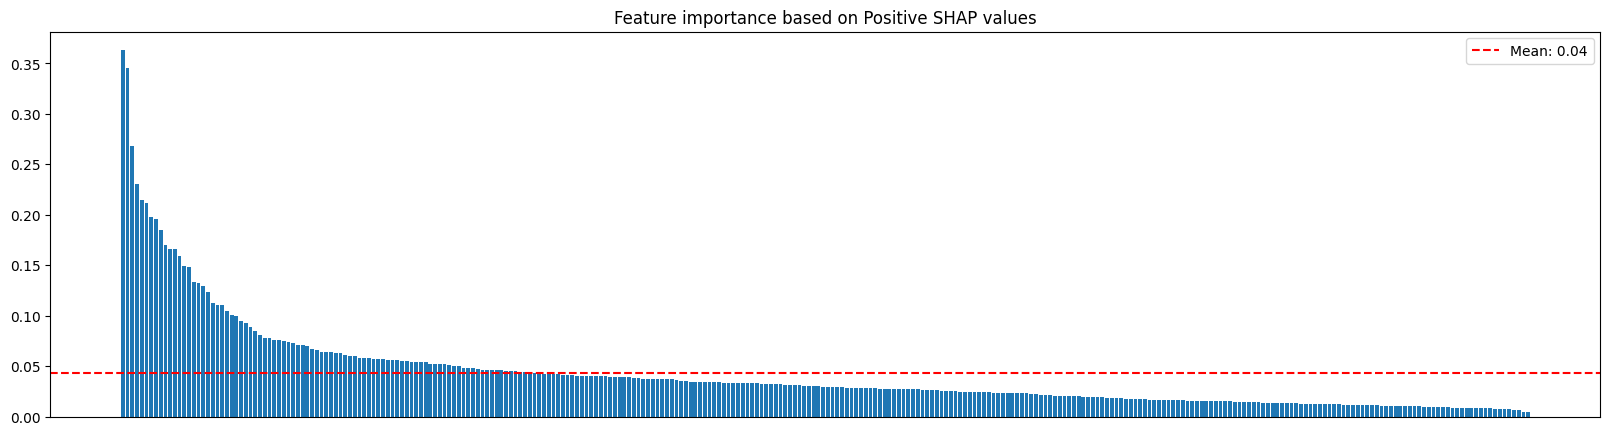

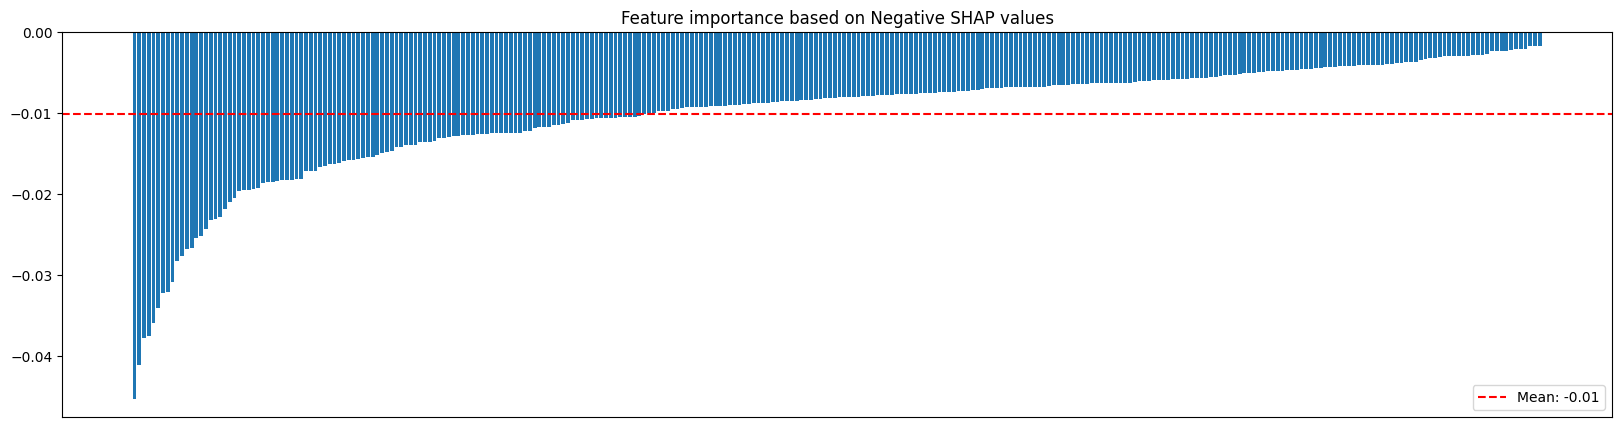

In [56]:
custom_global_shap_distribution(shap_values_bert[:,:,1], threshold=0.001)

# 7 Model Comparison

In [57]:
from model_helper.disagreements import get_disagreements

dtc_bert_sorted_by_diff,logreg_bert_sorted_by_diff,logreg_dtc_sorted_by_diff = get_disagreements(y_test,BERT_PREDICTION_FILE, LOGREG_PREDICTION_FILE, DTC_PREDICTION_FILE)

In [58]:
dtc_bert_sorted_by_diff.head(10)

,bert_0,bert_1,logreg_0,logreg_1,dtc_0,dtc_1,label,logreg_dtc_diff,logreg_bert_diff,dtc_bert_diff
1253,0.022319,0.977681,0.539190,0.460810,1.0,0.0,1,0.460810,0.516871,0.977681
1156,0.023951,0.976049,0.474162,0.525838,1.0,0.0,1,0.525838,0.450211,0.976049
535,0.025442,0.974558,0.794373,0.205627,1.0,0.0,1,0.205627,0.768931,0.974558
832,0.028629,0.971371,0.714204,0.285796,1.0,0.0,1,0.285796,0.685575,0.971371
1268,0.036012,0.963988,0.597666,0.402334,1.0,0.0,1,0.402334,0.561654,0.963988
672,0.038407,0.961593,0.553859,0.446141,1.0,0.0,0,0.446141,0.515452,0.961593
1192,0.039949,0.960051,0.647649,0.352351,1.0,0.0,1,0.352351,0.607700,0.960051
1138,0.041812,0.958188,0.682333,0.317667,1.0,0.0,1,0.317667,0.640521,0.958188
916,0.042152,0.957848,0.734561,0.265439,1.0,0.0,0,0.265439,0.692409,0.957848
651,0.044700,0.955300,0.683512,0.316488,1.0,0.0,1,0.316488,0.638812,0.955300


In [59]:
logreg_bert_sorted_by_diff.head(10)

,bert_0,bert_1,logreg_0,logreg_1,dtc_0,dtc_1,label,logreg_dtc_diff,logreg_bert_diff,dtc_bert_diff
955,0.040401,0.959599,0.845796,0.154204,0.772727,0.227273,1,0.073069,0.805395,0.732326
1708,0.048032,0.951968,0.836220,0.163780,0.866667,0.133333,0,0.030447,0.788188,0.818635
940,0.072164,0.927836,0.853346,0.146654,0.580645,0.419355,1,0.272701,0.781182,0.508481
552,0.074999,0.925001,0.848828,0.151172,0.761905,0.238095,1,0.086924,0.773830,0.686906
535,0.025442,0.974558,0.794373,0.205627,1.000000,0.000000,1,0.205627,0.768931,0.974558
849,0.061202,0.938798,0.826824,0.173176,0.333333,0.666667,0,0.493490,0.765621,0.272131
1055,0.055789,0.944211,0.805298,0.194702,0.820513,0.179487,1,0.015215,0.749510,0.764724
522,0.028352,0.971648,0.777514,0.222486,0.523810,0.476190,1,0.253704,0.749162,0.495458
249,0.072684,0.927316,0.820790,0.179210,1.000000,0.000000,0,0.179210,0.748106,0.927316
1169,0.086920,0.913080,0.834162,0.165838,1.000000,0.000000,1,0.165838,0.747242,0.913080


In [60]:
# sample 1253 is intresting because there is a big differenc between the predictions of the three models

In [61]:
bert_dtc_log_reg_biggest_difference_index = 1253
corpus_test[bert_dtc_log_reg_biggest_difference_index]

'fda biotechnology chief dr phil noguchi warned that the human cloning even if it worked risked transferring sexually transmitted diseases to the newly born child '

In [62]:
dtc_explanation = explainer_dtc([corpus_test[bert_dtc_log_reg_biggest_difference_index]])
logreg_explanation = explainer_logreg([corpus_test[bert_dtc_log_reg_biggest_difference_index]])

In [63]:
print('DTC Explanation')
highlight_signal_words(dtc_explanation[0,:,1],round_shap_values=3,top_words=6)
shap.plots.text(dtc_explanation[0,:,1])

DTC Explanation


In [64]:
print('logreg Explanation')
highlight_signal_words(logreg_explanation[0,:,1],round_shap_values=3,top_words=6)
shap.plots.text(logreg_explanation[0,:,1])

logreg Explanation


BERT Explanation


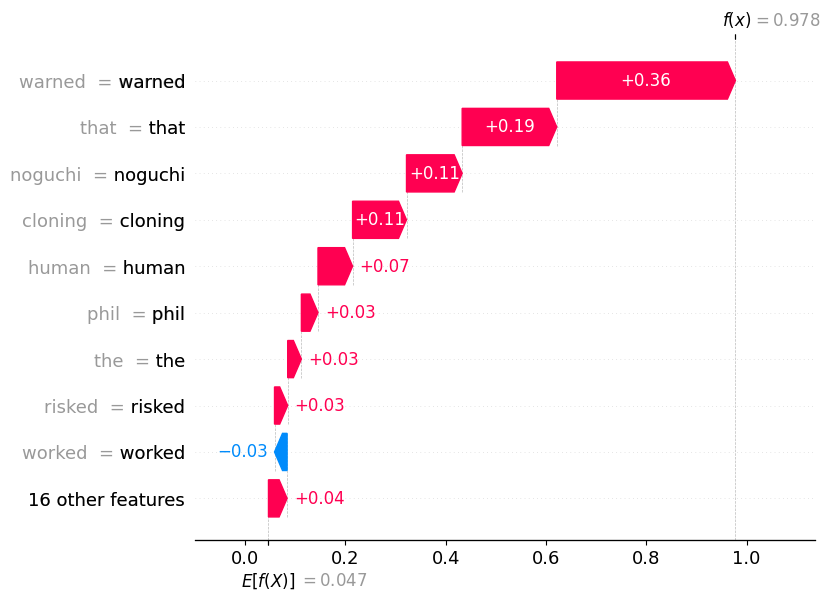

In [65]:
bert_explanation = explainer_bert([corpus_test[bert_dtc_log_reg_biggest_difference_index]])
bert_explanation = bert_explanation[0, :, 1]
print('BERT Explanation')
highlight_signal_words(bert_explanation,round_shap_values=3,top_words=6)
shap.plots.text(bert_explanation)
shap.plots.waterfall( bert_explanation)

# Interpretation

why is this a claim